# Calculate CMIP Indeces

This file 
1. calculates all the indeces for all months for all cesmFullForcingFiles.



In [1]:
#import my functions
import helpers.fileHandler as fh
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.sstIndex as sst
import utils.pslIndex as psl
import utils.timePeriod as tp
import utils.compound as compound


In [2]:
import xarray
import numpy
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings('ignore')

# 1. Calculate CMIP Indeces

For each experiment in historical, calculate indices

The heavy lifting - you need the output from this to proceed

In [4]:
deckSet=['piControl','historical']
scenarioSet=['ssp126', 'ssp245', 'ssp370','ssp585']
experimentSet=[*deckSet, *scenarioSet]

In [5]:
modelSet=_model.scenarioMip

In [6]:
sstIndeces = _index.sstIndex.keys()
pslIndeces = _index.pslIndex

This grabs the monthly CESM indeces, and calculates the averages for the time periods of interest (aka the warm season), as set in the _indexDefitionions file

Theres a few examples of output at the bottom to sanity check this is meaningful

The indeces for each month have already been calculated. So loading up the saved versions, and putting them into a single xarray.

In [7]:
for experiment in experimentSet: 
    print(experiment)
    timePIndeces=list()

    for model in _model.scenarioMip[:,1]:
        try:
            indecesDs = xarray.open_dataset('results/cmipWarmSeasonIndeces/' + model +'tos'+ experiment + '.nc')
            indecesDs['model']=model
            timePIndeces.append(indecesDs)
        except Exception as e:
            print('skipping' + model + experiment) 
    results=xarray.concat(timePIndeces, 'model')

    results=results.assign_attrs({'experiment':experiment,**indecesDs.attrs,**_index.monthsOfInterest})

    results.to_netcdf('results/cmip6'+experiment+'TradIndecestos.nc')

piControl
historical
skippingCESM2historical
skippingHadGEM3-GC31-LLhistorical
skippingHadGEM3-GC31-MMhistorical
ssp126
skippingCAS-ESM2-0ssp126
skippingCESM2ssp126
skippingCanESM5-CanOEssp126
skippingEC-Earth3-CCssp126
skippingGFDL-CM4ssp126
skippingHadGEM3-GC31-LLssp126
skippingHadGEM3-GC31-MMssp126
skippingMPI-ESM1-2-HRssp126
ssp245
skippingCAS-ESM2-0ssp245
skippingCESM2ssp245
skippingHadGEM3-GC31-LLssp245
skippingHadGEM3-GC31-MMssp245
skippingMPI-ESM1-2-HRssp245
ssp370
skippingCAS-ESM2-0ssp370
skippingCESM2ssp370
skippingCIESMssp370
skippingCanESM5-CanOEssp370
skippingEC-Earth3-CCssp370
skippingFIO-ESM-2-0ssp370
skippingGFDL-CM4ssp370
skippingHadGEM3-GC31-LLssp370
skippingHadGEM3-GC31-MMssp370
skippingMPI-ESM1-2-HRssp370
skippingNESM3ssp370
ssp585
skippingCAS-ESM2-0ssp585
skippingCESM2ssp585
skippingCanESM5-CanOEssp585
skippingHadGEM3-GC31-LLssp585
skippingHadGEM3-GC31-MMssp585
skippingMPI-ESM1-2-HRssp585


Some sanity checks to see if it looks ok:


In [8]:
results=xarray.open_dataset('results/cmip6ssp585TradIndecestos.nc').sel(year=slice(1850,2099))

In [9]:
str(results.isel(model=6).model.values)

'CMCC-CM2-SR5'

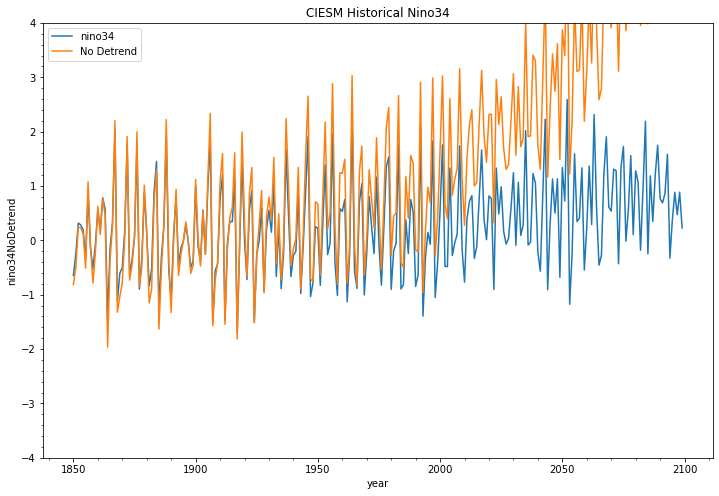

In [10]:
# plotSomething
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)

results.isel(model=5).nino34.plot(label='nino34')
results.isel(model=5).nino34NoDetrend.plot(label='No Detrend')

#Tidy up a bit
plt.title(str(results.isel(model=5).model.values) + " Historical Nino34")
plt.ylim(-4,4)
plt.minorticks_on()
plt.legend()

In [11]:
# A multi-model mean?

mean = results.sam.mean(dim='model')
std = results.sam.std(dim='model')

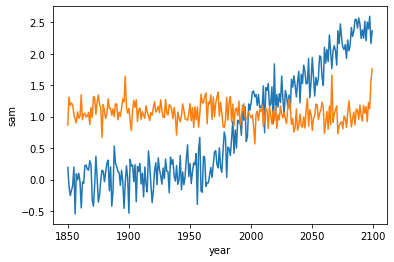

In [12]:
plt.figure()
mean.plot()
std.plot()

# 2. Calculate Compound Years for CESM6

# Define a criteria to determine events

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

Using a piControl climatology

In [13]:
piControlXr=xarray.open_dataset('results/cmip6piControlTradIndecestos.nc')

piControlXr.model.values

array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CAMS-CSM1-0',
       'CAS-ESM2-0', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CMCC-CM2-SR5',
       'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'CanESM5',
       'CanESM5-CanOE', 'EC-Earth3', 'EC-Earth3-CC', 'EC-Earth3-Veg',
       'EC-Earth3-Veg-LR', 'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4',
       'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'INM-CM4-8',
       'INM-CM5-0', 'IPSL-CM6A-LR', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3',
       'NorESM2-LM', 'NorESM2-MM', 'UKESM1-0-LL'], dtype=object)

In [14]:
# This should calculate stds for all experiments and all indeces
stdXr = piControlXr.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaXr= xarray.merge(
    (stdXr[['nino34','dmi']], stdXr['sam']/2)
)

In [15]:
criteriaXr

<xarray.Dataset>
Dimensions:  (model: 37)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    nino34   (model) float64 0.7126 0.5657 0.8038 1.008 ... 1.11 0.9884 0.739
    dmi      (model) float64 0.4608 0.6935 0.6296 ... 0.5769 0.5084 0.6019
    sam      (model) float64 0.6323 0.6126 0.5631 ... 0.5571 0.5387 0.5763

# Calculate the compounding years and plot an example

In [17]:
for experiment in experimentSet:

    # Here is the data
    indecesXr = xarray.open_dataset('results/cmip6'+experiment+'TradIndecestos.nc')

    firePos, fireNeg = compound.applyCriteria(indecesXr, criteriaXr)

    firePos=compound.compound(firePos)

    fireNeg=compound.compound(fireNeg)

    firePos.to_netcdf('results/cmip6'+experiment+'FirePos.nc')

    fireNeg.to_netcdf('results/cmip6'+experiment+'FireNeg.nc')

firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']
firePos: 
['dmi', 'nino34']
fireNeg: 
['sam']


In [ ]:
indecesXr.sel(year=2014)

In [ ]:
firePos

In [ ]:
modToPlot = 'CESM2'

toPlot=3*firePos.all3.sel(model=modToPlot)

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos[iPair].sel(model=modToPlot),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1850,2100)
plt.title(modToPlot+': Pairs and all-three compounds for individal years')